In [13]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Deep Neural Network (DNN)


![dnn](http://ufldl.stanford.edu/tutorial/images/Network3322.png)


* **neuron** is a unit that takes input vector and outputs a single value.
* **layer** is a set of neurons with the same input vector.
* **NN** is a set of layers that are serially connected.

## Neuron
![neuron](https://www.dropbox.com/s/b6juegvqmaul9zm/Neuron.png?dl=0&raw=1)
* A neuron defines a hyperplane and computes the distance from the hyperplane
* The distance is non-linearly transformed.

## Layer
* just a **linear (affine) map + coordinate-wise non-linear transform**
![nonlinear](https://upload.wikimedia.org/wikipedia/en/thumb/9/96/Jacobian_determinant_and_distortion.svg/1280px-Jacobian_determinant_and_distortion.svg.png)

## Implementation

Now let's implement NN in `tensorflow`!

### Layer
$$ h = \sigma (xw + b)$$
where
$ x \in \mathbb{R}^{n \times d}$,
$ w \in \mathbb{R}^{d \times h}$,
$ b \in \mathbb{R}^{h}$,
$ h \in \mathbb{R}^{n \times h}$ 
and $\sigma(\cdot)$ is a non-linear activation function.

Let us define the tensors.

In [14]:
tf.reset_default_graph()

x = tf.placeholder('float32', name='x')

initial_w = tf.truncated_normal(
                shape=(784, 50),
                mean=0.0, stddev=0.05 )
w = tf.Variable(initial_w, name='w')
b = tf.Variable(tf.zeros(shape=(50,)), name='b')

p = tf.matmul(x, w) + b
h = tf.sigmoid(p)

In [15]:
print x
print w
print b
print p
print h

Tensor("x:0", dtype=float32)
Tensor("add:0", shape=(?, 50), dtype=float32)
Tensor("Sigmoid:0", shape=(?, 50), dtype=float32)


Now, let's evaluate

In [16]:
try:
    sess.close()
except NameError:
    pass
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Load values on GPU
init = tf.initialize_all_variables()
sess.run(init) 

print "w: \n", sess.run(w)
print "b: \n", sess.run(b)
# print sess.run(p)  # Error. Cause we did not fed the `x`
print "p shape: \n", sess.run(tf.shape(p), feed_dict={x: np.zeros(shape=(10,784))})

w: 
[[ 0.01170039  0.03081924 -0.03341355 ..., -0.05013648  0.06999285
  -0.02501209]
 [ 0.09782187 -0.05770919  0.05078177 ...,  0.04800818 -0.02364256
   0.04929907]
 [-0.0192522  -0.0016696  -0.00286393 ...,  0.03492413  0.00486213
   0.02429403]
 ..., 
 [ 0.04579539  0.07084817  0.02263879 ..., -0.03819674 -0.01520984
   0.00336086]
 [ 0.03129913  0.00667761 -0.00481091 ..., -0.0376614   0.09721918
   0.03021369]
 [ 0.06360533  0.04421287  0.04556337 ...,  0.03088005  0.01524972
   0.00981149]]
b: 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
p shape: 
[10 50]


### Set of Layers
To stack the layers, let us generalize a little bit the above.

In [17]:
layer_spec = [784, 100, 30, 10]
n_layer = len(layer_spec)-1
print "num of layers: ", n_layer

num of layers:  3


Note that the final layer of NN is logistic regression.

In [18]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, name='x')

inp = x
hs = []
for l in xrange(n_layer):
    with tf.name_scope('p{}'.format(l)):

        initial_w = tf.truncated_normal(
                shape=(layer_spec[l], layer_spec[l+1]),
                mean=0.0, stddev=0.05)
        w = tf.Variable(initial_w, name='w')
        b = tf.Variable(tf.zeros((layer_spec[l+1],)), name='b')
        p = tf.matmul(inp,w) + b

    with tf.name_scope('h{}'.format(l)):

        if l == n_layer-1: # Last layer
            h = p
        else: 
            h = tf.nn.relu(p)
        hs.append(h)
        inp = h

In [19]:
try:
    sess.close()
except NameError:
    pass
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Load values on GPU
init = tf.initialize_all_variables()
sess.run(init) 

print "h shape: \n", sess.run(tf.shape(hs[-1]), feed_dict={x: np.zeros(shape=(30,784))})

h shape: 
[30 10]


### Loss
We define the loss as the **negative log-likelihood**, or the **cross-entropy**.
$$\sum_i \sum_k -\mathcal{I}(t_i=k) \log P(y_i=k|x_i;\theta)$$

In [21]:
t = tf.placeholder('int32', name='t')
xent = tf.nn.sparse_softmax_cross_entropy_with_logits(
            hs[-1], t, name='xent')

loss = tf.reduce_mean(xent, name='loss')
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#pred = tf.argmax(hs[-1], axis=1)
pred = tf.reduce_max(hs[-1], reduction_indices=[1])


correct = tf.nn.in_top_k(hs[-1], t, 1)
acc = tf.reduce_mean(tf.cast(correct, tf.float32))


### Load Data
We use MNIST hand-written digit recognition data.
* Total 70k images
* 784 dimension (28x28 pixels, gray-scale) 
* Train, Test, Validation Sets are divided a priori.

The objective is to classify each image as one of 10 classes (0-9).

[u'test_t', u'test_x', u'train_t', u'train_x', u'valid_t', u'valid_x']
(55000, 784)
class:  7


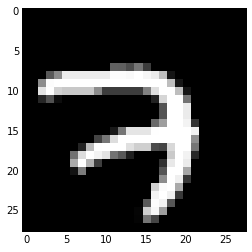

In [24]:
import h5py
mnist = h5py.File('../mnist.hdf5','r')
print mnist.keys()
print mnist['train_x'].shape

train_x = mnist['train_x'][()]
train_t = mnist['train_t'][()]

plt.imshow(train_x[0].reshape((28, 28)), 
               interpolation='nearest', cmap=plt.get_cmap('gray'))
print "class: ", train_t[0]

### Stochastic Gradient Descent
Loss:
$$ \mathcal{L}(X; \theta) = \frac{1}{n} \sum_{i=1}^n \mathcal{L(x_i; \theta)}$$
Gradient Descent:
$$ \theta^{t+1} = \theta^{t} - \eta \frac{1}{n}\sum_{i=1}^n \frac{\partial \mathcal{L}(X_i;\theta)}{\partial \theta} \vert _{\theta=\theta^t} $$

Stochastic Gradient Descent:

---
**for** $k=1$ **to** $n/m$:
$$ \theta^{k+1} = \theta^{k} - \eta \frac{1}{k}\sum_{i=1}^m \frac{\partial \mathcal{L}(X_i;\theta)}{\partial \theta} \vert _{\theta=\theta^k} $$
**end**

$\theta^{t+1}=\theta^{k=n/m}$

---
**Principle**:

*Instead of computing the exact gradient direction using the full batch data and update once, compute a **noisy gradient** direction using partial (mini-batch) data and update **multiple times**.*

Epoch: 0, Loss: 2.29871177673, Acc: 0.173999994993
Epoch: 1, Loss: 2.27780485153, Acc: 0.306909114122
Epoch: 2, Loss: 2.21257591248, Acc: 0.360654532909
Epoch: 3, Loss: 1.96100187302, Acc: 0.43969091773
Epoch: 4, Loss: 1.49118208885, Acc: 0.592581868172
Epoch: 5, Loss: 1.06805336475, Acc: 0.694236397743
Epoch: 6, Loss: 0.800314426422, Acc: 0.770963609219
Epoch: 7, Loss: 0.647313117981, Acc: 0.8166000247
Epoch: 8, Loss: 0.563945233822, Acc: 0.8405636549
Epoch: 9, Loss: 0.512508392334, Acc: 0.855327248573
Epoch: 10, Loss: 0.476745158434, Acc: 0.865672707558
Epoch: 11, Loss: 0.449486494064, Acc: 0.872727274895
Epoch: 12, Loss: 0.427356809378, Acc: 0.878509104252
Epoch: 13, Loss: 0.408805549145, Acc: 0.884290874004
Epoch: 14, Loss: 0.392937600613, Acc: 0.888327300549
Epoch: 15, Loss: 0.379130154848, Acc: 0.892618179321
Epoch: 16, Loss: 0.366949230433, Acc: 0.895709037781
Epoch: 17, Loss: 0.356020629406, Acc: 0.899272739887
Epoch: 18, Loss: 0.346040070057, Acc: 0.902090907097
Epoch: 19, Los

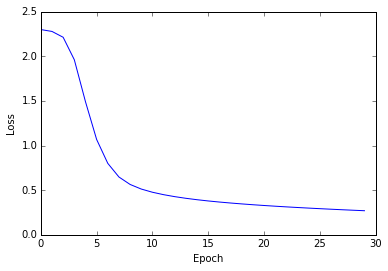

In [26]:

num_train = train_x.shape[0]
mb_size = 200
num_mbs = int(num_train / mb_size)

loss_history = []
for epoch in xrange(30):
    loss_vals = []
    acc_vals = []
    for mb in xrange(num_mbs):
        data_x = train_x[mb*mb_size : (mb+1)*mb_size] 
        data_t = train_t[mb*mb_size : (mb+1)*mb_size] 

        _, loss_val, acc_val = sess.run([train_step, loss, acc], 
                                            feed_dict={x: data_x, t: data_t})
        loss_vals.append(loss_val)
        acc_vals.append(acc_val)
        
    print "Epoch: {}, Loss: {}, Acc: {}".format(
        epoch, np.mean(loss_vals), np.mean(acc_vals) )

    loss_history.append(np.mean(loss_vals))

plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [27]:
test_x = mnist['test_x']
test_t = mnist['test_t']
test_mb_size = 200
test_num_mbs = test_x.shape[0] / test_mb_size

test_accs = []
for mb in xrange(test_num_mbs):
    test_acc = sess.run(acc, feed_dict={
        x: test_x[mb*test_mb_size : (mb+1)*test_mb_size],
        t: test_t[mb*test_mb_size : (mb+1)*test_mb_size]})
    test_accs.append(test_acc)
print "test acc: ", np.mean(test_accs)

test acc:  0.9274
